In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from haven import haven_utils as hu
import open3d as o3d
from open3d.web_visualizer import draw
o3d.visualization.webrtc_server.enable_webrtc()

import numpy as np
import torch
import torch.nn
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from src import models
from src.scenes import NeuralScene
from src.pointcloud_lightfield.ptlf_vis import get_pcd_vis
from src import utils as ut

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.
[Open3D INFO] WebRTC GUI backend enabled.


In [2]:
# Define Path to model checkpoint and dataset
savedir = '/home/julian/experiments/encodings_pointcloud/v26/30h/23c7dd1220f6b8265fca7fafdc005d6c'
datadir = '/home/julian/data/waymo_open/validation'

# Load checkoiubt
exp_dict = hu.load_json(os.path.join(savedir, 'exp_dict.json'))
model_state_dict = hu.torch_load(os.path.join(savedir, 'model.pth'))

In [17]:
# If running localy, change computational settings
exp_dict['n_rays'] = 1024
exp_dict['chunk'] = 512

In [18]:
# Create Scene
seed = 42 + exp_dict.get("runs", 0)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

args = None

scene = NeuralScene(
    scene_list=exp_dict["scenes"],
    datadir=datadir,
    args=args,
    exp_dict=exp_dict,
)

model = models.Model(scene, exp_dict, precache=exp_dict.get("precache"))

# Load checkpoint
model.renderer.load_state_dict(
        model_state_dict["renderer"], strict=False
    )

# Load checkpoint
# chk_dict = hw.get_checkpoint(savedir, return_model_state_dict=True)

# if len(chk_dict["model_state_dict"]):
#     model.set_state_dict(chk_dict["model_state_dict"])

Loaded Waymo

loaded scene segment-10247954040621004675_2180_000_2200_000_with_camera_labels with 205 frames.
Loaded Nodes in 0.003 seconds


Loaded Frames in 4.305 seconds


/home/julian/anaconda3/envs/TorchSceneGraphs/lib/python3.7/site-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


<All keys matched successfully>

In [19]:
batch_size = 1
epoch_size = 1
rand_sampler = torch.utils.data.RandomSampler(
    scene, num_samples=epoch_size * batch_size, replacement=True
)

scene_loader = torch.utils.data.DataLoader(
    scene,
    sampler=rand_sampler,
    collate_fn=ut.collate_fn_dict_of_lists,
    batch_size=batch_size,
    num_workers=0,
    # pin_memory=True,
    drop_last=True,
)

In [20]:
ind_list = list(np.arange(len(scene)))
bi = ind_list[0]

b = ut.collate_fn_dict_of_lists(
    [scene.__getitem__(bi, intersections_only=True, random_rays=True)]
)

In [21]:
b['pts_dirs'][0][(1,0)].shape

torch.Size([512, 3])

In [22]:
rgb_out = model.renderer.forward_on_batch(b)

/home/julian/workspace/NeuralSceneGraphs/src/pointcloud_lightfield/pointcloud_encoding/simpleview.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).float()


In [23]:
list(rgb_out.keys())

['points_in',
 'points_selected_in',
 'rays_in',
 'closest_mask_in',
 'samples',
 'points_scaled',
 'sum_mv_point_features',
 'attention_weights',
 'raw_point_features',
 'selected_point_features',
 'per_ray_features',
 'color_out',
 'rgb',
 'ray_bundle',
 'xycfn',
 'gt']

In [24]:
def get_feat_color(feat):
    assert len(feat.shape) == 2
    feat_embedded = TSNE(n_components=3).fit_transform(feat)
    feat_embedded = feat_embedded - feat_embedded.min(axis=0)
    color = feat_embedded / feat_embedded.max(axis=0)
    return color

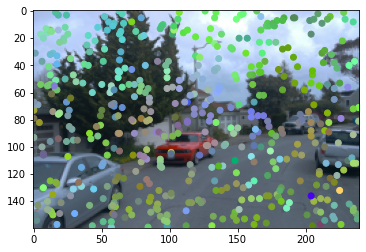

In [25]:
ray_feat = rgb_out["per_ray_features"].squeeze()


px_color = get_feat_color(ray_feat)

rb = rgb_out['ray_bundle']
xy = rb.xys[..., :2].squeeze().cpu().numpy()
img = scene.frames[0].load_image(1)
# img[xy[:, 1], xy[:, 0]] = px_color
plt.imshow(img)
plt.scatter(xy[:, 0], xy[:, 1], c=px_color)

In [11]:
k = 0

pts = rgb_out['points_in'][k]
mask = rgb_out['closest_mask_in'][k]
feat_per_pts = rgb_out['sum_mv_point_features'].squeeze()
if len(feat_per_pts.shape) == 4:
    feat_per_pts = feat_per_pts[k]
    
n_rays, k_closest, feat_dim = feat_per_pts.shape
feat_per_pts = feat_per_pts.reshape(-1, feat_dim)

In [26]:
pt_color = get_feat_color(feat_per_pts)

In [28]:
pcd = get_pcd_vis(pts)
pcd.paint_uniform_color([1., 0.9, 0.])

pcd_closest = get_pcd_vis(pts[mask], color_vector=pt_color)

draw([pcd, pcd_closest])

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.26281214487423954
[Open3D INFO] DataChannelObserver

[150:738][16214] (webrtc_sdp.cc:420): Failed to parse: "". Reason: Expect line: candidate:<candidate-str>


[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D WARNING] Can't parse received candidate message.


[179:310][16286] (stun_port.cc:96): Binding request timed out from 192.168.178.x:38753 (wlp0s20f3)
[179:310][16286] (stun_port.cc:96): Binding request timed out from 10.3.8.x:58365 (tun1)
[179:463][16286] (stun_port.cc:96): Binding request timed out from 192.168.178.x:38753 (wlp0s20f3)


In [ ]:
frame_id =
camera_id =

# Make sure rays are not randomly sampled
model.eval()
model.renderer.forward()
model.renderer._process_chunk()

# Might need to run the pipeline manually

# 1. Sample a set of adjacent rays

# 2. Run rest of the pipeline

# 3. Generate standard output


# 4. Ablation Outputs a) b) c) ...